In [1]:
# Requirements: numpy, matplolib, skopt

import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from math import inf

plt.style.use("seaborn")

This notebook details how to use bayesian optimization to minimize a function, with a special focus on optimizing hyperparameters. Note that if you are exclusively using scikit learn models, there is a more streamlined version at https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html. The present notebook is useful when you are using your own models.

# 1. Presentation of the problem
We wish to solve

$$ x^* = \textrm{argmin}_{x \in \Omega}f(x) $$ 
First when shoud you use bayesian optimization to minimize a function $f(x)$? 

1. When gradients $\nabla_x f(x)$ are not available.
2. When the dimension of $x$ is not too large (a common number is $d \leq 20$).

Additionally, bayesian optimization is particulary good when: 

1. Computing the function $f(x)$ is expensive.
2. The evaluations of the function $f(x)$ are noisy.

Bayesian optimization can deal with the case where $\Omega \subset \mathbb{R}^d$ or $\Omega \subset \mathbb{N}^d$ (or a mix).
# 2. The bayesian optimization algorithm

Bayesian optimization is an iterative algorithm:

1. Sample N initial points in $x_i \in \Omega$ and compute $y_i = f(x_i) + \varepsilon$ .
2. Fit a GP regressor on $(x_i, y_i)$. 
3. For $1 \leq t \leq T$ iterations, do:
    1. Select $x_{t+1}$ by minimizing some criterion. Typically $\mathbb{E}[f(x) - f(x^*_t)]$ where $x^*_t$ is the best point at time t, but other criteria with closed form solutions exist.
    2. Fit the GP regressor given the new data point $(x_{t+1}, y_{t+1})$.
4. Return the best $x^*$ and $f(x^*)$.


# 3. Bayesian optimization for hyperparameter tuning

For this method you need three things:

1. A dataset.
2. A method to fit your model on a (subset) of the  data set. 
3. A function $\mathcal{L}$ to measure the performance of the model on a validation set (scoring function).

In this application $x = \theta$ is a set of hyper-parameters for your model and $f = \mathcal{L}$. We wish to select

$$ x^* = \textrm{argmin}_{x \in \Omega}\mathbf{E}_{}[\mathcal{L}(\theta)] $$ 

where the expectation is taken over all possible train/validation splits of the full data set. 

In practice, $\mathbf{E}_{}[\mathcal{L}(\theta)]$ is intractable. Hence we will estimate it with by sampling $n$ train/validation sets. We present two variants of the approach: the more traditional cross validation approach with a fixed number of train/validation splits and the randomized approach. 

# 4. Worked examples

## Generate the data

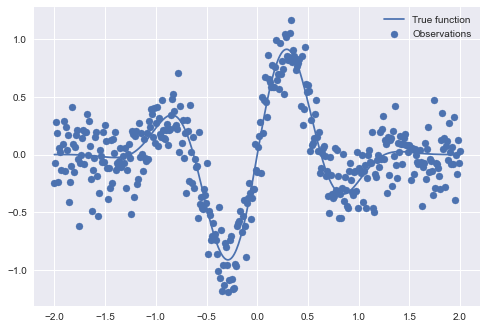

In [39]:
noise_level = 0.2


def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level


x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = np.array([f(x_i, noise_level=0.0) for x_i in x])
y = np.array([f(x_i, noise_level=noise_level) for x_i in x])

plt.plot(x, fx, label = "True function")
plt.scatter(x, y, label = "Observations")
plt.legend()

In [40]:
# Create a train/test split

from sklearn.model_selection import train_test_split, KFold

X, X_test, Y, Y_test = train_test_split(x,y, test_size = 0.2, random_state=2022, shuffle = True) 

## Model

For this toy problem, we will use a GP regressor with Matern covariance function. This model has 3 hyper-parameters:

1. Regularization $\alpha \in \mathbb{R}_{+}$.
2. Legthscale $l \in \mathbb{R}_{+}$.
3. Smoothness parameter $\nu \in [0.5, 1.5, 2.5, \infty]$ 

## Scoring function

The scoring function is the MSE.


In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error as mse

In [42]:
# GP with default parameters
k = Matern(length_scale = 1.0, nu = 1.5, length_scale_bounds = "fixed")
gp = GaussianProcessRegressor(kernel = k, alpha = 1e-10)
gp.fit(X, Y)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5))

In [43]:
pred = gp.predict(X_test)

print("The mean squared error on the test set is", np.round(mse(pred, Y_test), 3))

The mean squared error on the test set is 0.092


## Bayesian optimization: fixed cross validation

In [44]:
def score_function(prediction, Y_val):
    
    return mse(prediction, Y_val)

n_splits = 5
#seed_list = [2020, 2021, 2022, 2023, 2024]
# The objective we wish to minimize
def objective(parameters):
    """
    Input is a list the size of the parameters
    """
    # Select the hyper-parameters of your model
    l = parameters[0]
    nu = parameters[1]
    alpha = parameters[2]
    
    k = Matern(length_scale = l, nu = nu, length_scale_bounds = "fixed")
    gp = GaussianProcessRegressor(kernel = k, alpha = alpha)
    
    score = 0
    
    # Build a cross k fold cross validation split
    kf = KFold(n_splits=n_splits)
    
    
    
    for train_index, val_index in kf.split(X):
        
        # Extract the split
        X_train = X[train_index]
        Y_train = Y[train_index]
        
        X_val = X[val_index]
        Y_val = Y[val_index]
        
        # Fit your model
        gp.fit(X_train, Y_train)
        
        # Prediction on the validation split
        prediction = gp.predict(X_val)
        
        # Evaluate the score on the split
        score = score_function(prediction, Y_val)
        
    return score/n_splits
        
        
        
    

In [45]:
# Define the search space, naming is optional
from skopt.space import Real, Integer, Categorical 

space  = [Real(10**-3, 10**2, name='length_scale'),
          Categorical([0.5, 1.5, 2.5, inf], name='nu'),
          Real(10**-10, 10**1, name='alpha'),
          
         ]

In [46]:
res = gp_minimize(objective,                  # the function to minimize
                  space,      # the search space
                  acq_func="EI",      # the acquisition function
                  n_calls=20,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  random_state=1234,  # the random seed
                  verbose = False,    # set to True for longer runs
                 )   

In [47]:
res.x, res.fun

([0.034632841857825204, inf, 1.7114660134371937], 0.00966857331819053)

In [48]:
l_opt = res.x[0]
nu_opt = res.x[1]
alpha_opt = res.x[2]

k = Matern(length_scale = l_opt,  nu = nu_opt, length_scale_bounds = "fixed")
gp = GaussianProcessRegressor(kernel = k, alpha = alpha_opt)
gp.fit(X, Y)

pred = gp.predict(X_test)

print("The mean squared error on the test set is", np.round(mse(pred, Y_test), 3))

The mean squared error on the test set is 0.054


## Bayesian optimization: randomized cross validation

In [49]:
"""
Same as above, but this time each train/validation split is random at each iteration.

Downside is that each optimization run is different and will typically take longer to converge to the same solution.
Upside is that is not bound to a fixed number of train/validation splits. Hence over long runs, will explore more 
splits  and hence will provide a better estimate of E[l(\theta)].
"""

n_splits = 5

# The objective we wish to minimize
def objective(parameters):
    """
    Input is a list the size of the parameters
    """
    # Select the hyper-parameters of your model
    l = parameters[0]
    nu = parameters[1]
    alpha = parameters[2]
    
    k = Matern(length_scale = l, nu = nu, length_scale_bounds = "fixed")
    gp = GaussianProcessRegressor(kernel = k, alpha = alpha)
    
    score = 0
    for i in range(n_splits):
        

        
        # Select a train/validation split 
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.4, random_state=None)
        
        # Fit your model
        gp.fit(X_train, Y_train)
        
        # Predict
        prediction = gp.predict(X_val)
        
        # Evaluate the score on the split
        score = score_function(prediction, Y_val)
        
    return score/n_splits
        
        
        
    

In [50]:
# Define the search space, naming is optional
from skopt.space import Real, Integer, Categorical 

space  = [Real(10**-3, 10**2, name='length_scale'),
          Categorical([0.5, 1.5, 2.5, inf], name='nu'),
          Real(10**-10, 10**1, name='alpha'),
          
         ]

In [51]:
res = gp_minimize(objective,                  # the function to minimize
                  space,      # the search space
                  acq_func="EI",      # the acquisition function
                  n_calls=20,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  random_state=1234,  # the random seed
                  verbose = False,    # set to True for longer runs
                 )   

In [52]:
res.x, res.fun

([2.1317745532202244, 0.5, 1.5773035950009697], 0.0127794328811495)

In [53]:
l_opt = res.x[0]
nu_opt = res.x[1]
alpha_opt = res.x[2]

k = Matern(length_scale = l_opt,  nu = nu_opt, length_scale_bounds = "fixed")
gp = GaussianProcessRegressor(kernel = k, alpha = alpha_opt)
gp.fit(X, Y)

pred = gp.predict(X_test)

print("The mean squared error on the test set is", np.round(mse(pred, Y_test), 3))

The mean squared error on the test set is 0.057
